In [1]:
# This is a test script to verify the S2SVAE3 model can be used for inference.

import os
import sys
sys.path.append('/home/longshen/work/AccGen/AccGen')
import torch
from models.phrase_vae import load_t5_model_from_lit_ckpt
from models.vae_inference import BarVAE


model = BarVAE()

/home/longshen/programs/miniconda3/envs/accgen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Prepare tokenizer
from transformers import PreTrainedTokenizerFast
tokenizer_path = 'LongshenOu/phrase-vae-tokenizer'
tok = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)

In [3]:
# Prepare data
from sonata_utils import read_jsonl
jsonl_fp = '/data1/longshen/Datasets/Piano/POP909/jsonl/bar_level/val.jsonl'
data = read_jsonl(jsonl_fp)
bar1 = data[8]
bar2 = data[108]
print(bar1)
print(bar2)

i-13 o-0 p-60 d-6 o-6 p-60 d-3 o-9 p-60 d-6 o-18 p-62 d-3 o-21 p-64 d-3 o-24 p-62 d-3 o-30 p-60 d-3 o-33 p-60 d-6 o-42 p-60 d-3 o-45 p-62 d-3 i-25 o-0 p-55 d-24 p-52 d-24 o-36 p-60 d-9 p-57 d-9 i-0 o-0 p-55 d-3 p-48 d-9 p-36 d-24 o-6 p-43 d-9 o-12 p-55 d-9 p-48 d-9 o-24 p-52 d-12 p-48 d-12 p-33 d-18 o-36 p-57 d-12 p-52 d-12 p-48 d-3 o-42 p-48 d-6 b-1
i-13 o-30 p-64 d-6 o-36 p-69 d-6 o-42 p-71 d-6 b-1


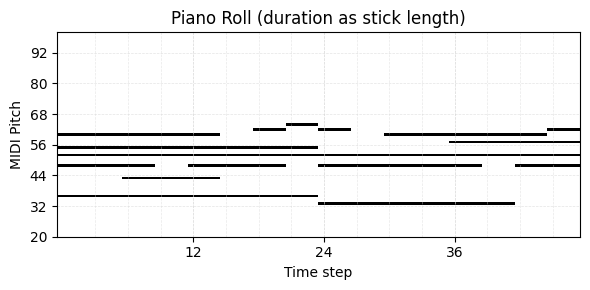

In [4]:
# Draw the two bars
from piano_roll_utils import save_piano_roll
from remi_z import MultiTrack

bar1_mt = MultiTrack.from_remiz_str(bar1)[0]
proll1 = bar1_mt.to_piano_roll(pos_per_bar=48)
save_piano_roll(proll1, 'bar1.png', show=True)

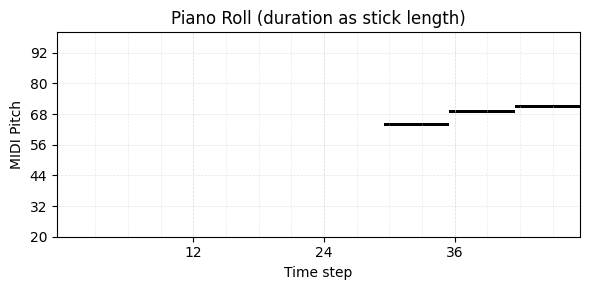

In [5]:
bar2_mt = MultiTrack.from_remiz_str(bar2)[0]
proll2 = bar2_mt.to_piano_roll(pos_per_bar=48)
save_piano_roll(proll2, 'bar2.png', show=True)  

In [6]:
latents = model.encode_batch([bar1, bar2], do_sample=False)
print(latents.shape)

torch.Size([2, 512])


i-13 o-0 p-60 d-6 o-6 p-60 d-3 o-9 p-60 d-6 o-18 p-62 d-3 o-21 p-64 d-3 o-24 p-62 d-3 o-30 p-60 d-3 o-33 p-60 d-6 o-42 p-60 d-3 o-45 p-62 d-3 i-25 o-0 p-55 d-24 p-52 d-24 o-36 p-60 d-9 p-57 d-9 i-0 o-0 p-55 d-3 p-48 d-9 p-36 d-24 o-6 p-43 d-9 o-12 p-55 d-9 p-48 d-9 o-24 p-52 d-12 p-48 d-12 p-33 d-18 o-36 p-57 d-12 p-52 d-12 p-48 d-3 o-42 p-48 d-6 b-1
i-13 o-30 p-64 d-6 o-36 p-69 d-6 o-42 p-71 d-6 b-1


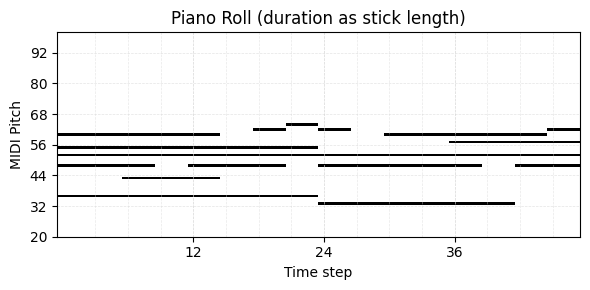

MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/bar1_recon.mid


In [7]:
from sonata_utils import jpath, create_dir_if_not_exist

# Check piano roll reconstruction
recon_str = model.decode_batch(latents.unsqueeze(1))
print(recon_str[0])
print(recon_str[1])
recon_mts = model.decode_batch(latents.unsqueeze(1), return_mt=True)
proll1_rec = recon_mts[0][0].to_piano_roll(pos_per_bar=48)
proll2_rec = recon_mts[1][0].to_piano_roll(pos_per_bar=48)
bar1_rec = recon_mts[0]
bar2_rec = recon_mts[1]

save_piano_roll(proll1_rec, 'bar1_rec.png', show=True)
save_dir = '/data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt'
save_fp = jpath(save_dir, 'bar1_recon.mid')
bar1_rec.to_midi(save_fp, tempo=90)

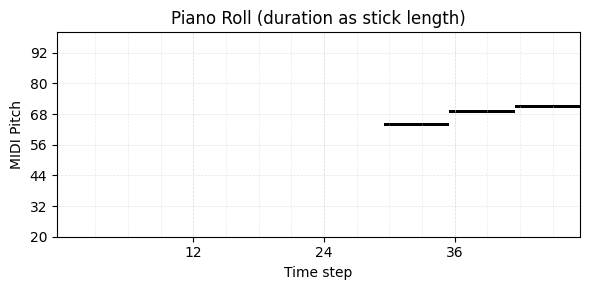

MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/bar2_recon.mid


In [8]:
# Check reconstructed proll2
save_piano_roll(proll2_rec, 'bar2_rec.png', show=True)
save_fp = jpath(save_dir, 'bar2_recon.mid')
bar2_rec.to_midi(save_fp, tempo=90)

torch.Size([1, 512]) torch.Size([1, 512])


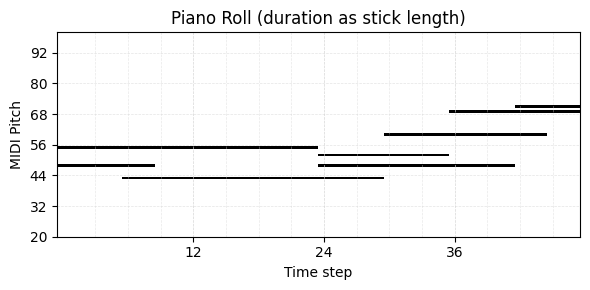

MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/bar_avg.mid


In [9]:
# Average the two latents
latents1 = latents[0:1]
latents2 = latents[1:2]
print(latents1.shape, latents2.shape)
latents_avg = (latents1 + latents2) / 2
mt_avg = model.decode_batch(latents_avg.unsqueeze(1), return_mt=True)[0]
proll_avg = mt_avg[0].to_piano_roll(pos_per_bar=48)
save_piano_roll(proll_avg, 'bar_avg.png', show=True)

create_dir_if_not_exist(save_dir)
save_fp = jpath(save_dir, 'bar_avg.mid')
mt_avg.to_midi(save_fp, tempo=90)

In [10]:
# Weighted interpolation
# save_dir = '/home/longshen/work/AccGen/test_outputs/vae/bar_level/4q/interpolate'
weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
interp_dir = jpath(save_dir, 'interp')
proll_save_dir = jpath(interp_dir, 'prolls')
os.makedirs(proll_save_dir, exist_ok=True)
latents1 = latents[0:1]
latents2 = latents[1:2]
for w in weights:
    latents_interp = (1-w) * latents1 + w * latents2
    mt_interp = model.decode_batch(latents_interp.unsqueeze(1), return_mt=True)[0]
    proll_interp = mt_interp[0].to_piano_roll(pos_per_bar=48)
    proll_fp = jpath(proll_save_dir, f'bar_interp_w{w:.1f}.png')
    save_piano_roll(proll_interp, proll_fp, show=False)
    midi_fp = jpath(interp_dir, f'bar_interp_w{w:.1f}.mid')
    mt_interp.to_midi(midi_fp, tempo=90)

MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/interp/bar_interp_w0.0.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/interp/bar_interp_w0.1.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/interp/bar_interp_w0.2.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/interp/bar_interp_w0.3.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/interp/bar_interp_w0.4.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/interp/bar_interp_w0.5.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/interp/bar_interp_w0.6.mid
MIDI file suc

In [18]:
# Do for another pair
from sonata_utils import create_dir_if_not_exist
from the_utils.midi_utils import save_midi
# random select two bar ids
import numpy as np
id1 = np.random.randint(0, len(data))
id2 = np.random.randint(0, len(data))
bar3 = data[id1]
bar4 = data[id2]
pair_save_dir = jpath(save_dir, f'pair_{id1}_{id2}')
create_dir_if_not_exist(pair_save_dir)
proll_dir = jpath(pair_save_dir, 'prolls')
create_dir_if_not_exist(proll_dir)
print(f'Selected bar ids: {id1}, {id2}')

new_latents = model.encode_batch([bar3, bar4], do_sample=False)
bar3_latents = new_latents[0:1]
bar4_latents = new_latents[1:2]

weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for w in weights:
    latents_interp = (1-w) * bar3_latents + w * bar4_latents
    mt_interp = model.decode_batch(latents_interp.unsqueeze(1), return_mt=True)[0]
    proll_interp = mt_interp[0].to_piano_roll(pos_per_bar=48)
    proll_fp = jpath(proll_dir, f'bar_interp_w{w:.1f}.png')
    midi_fp = jpath(pair_save_dir, f'bar_interp_w{w:.1f}.mid')
    save_piano_roll(proll_interp, proll_fp, show=False)
    mt_interp.set_velocity(70, 13)
    save_midi(mt_interp, midi_fp)

Selected bar ids: 572, 5515


In [20]:
# Sample directly
from sonata_utils import create_dir_if_not_exist
sample_save_dir = jpath(save_dir, 'prior_sampling')
create_dir_if_not_exist(sample_save_dir)
z_random = torch.randn(10, 1, 512)
# scale_factor = 0.723112
# z_random = z_random * scale_factor

# dim_mean = torch.load('/data1/longshen/Datasets/Piano/POP909/latents/bar_level/vae3/latent_dim_mean.pt')
# dim_std = torch.load('/data1/longshen/Datasets/Piano/POP909/latents/bar_level/vae3/latent_dim_std.pt')
# z_random = z_random * dim_std.unsqueeze(0) + dim_mean.unsqueeze(0)

mts = model.decode_batch(z_random, return_mt=True)
for i, mt in enumerate(mts):
    proll = mt[0].to_piano_roll(pos_per_bar=48)
    save_piano_roll(proll, jpath(sample_save_dir, f'bar_sample_{i}.png'))
    save_fp = jpath(sample_save_dir, f'bar_sample_{i}.mid')
    mt.to_midi(save_fp, tempo=90)

MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/prior_sampling/bar_sample_0.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/prior_sampling/bar_sample_1.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/prior_sampling/bar_sample_2.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/prior_sampling/bar_sample_3.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/prior_sampling/bar_sample_4.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/prior_sampling/bar_sample_5.mid
MIDI file successfully written to /data1/longshen/Results/AccGenResults/test_outputs/vae/bar_level/interpolate_mt/prior_samp